In [1]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import googletrans
import time
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("../Data/HateSpeechText_new.csv",sep=";",encoding="latin-1")
data.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


In [3]:
data.shape

(18396, 13)

## Data Analysis

### Perbandingan jumlah tiap label

In [4]:
label_size0 = []
label_size1 = []

for i in data.columns[1:]:
    label_size0.append(len(data[data[i]==0]))
    label_size1.append(len(data[data[i]==1]))

In [5]:
dat_anls = pd.DataFrame({
    'label' : data.columns[1:],
    'negative' : label_size0,
    'positive' : label_size1
})

dat_anls = dat_anls.set_index(['label'], drop=True)

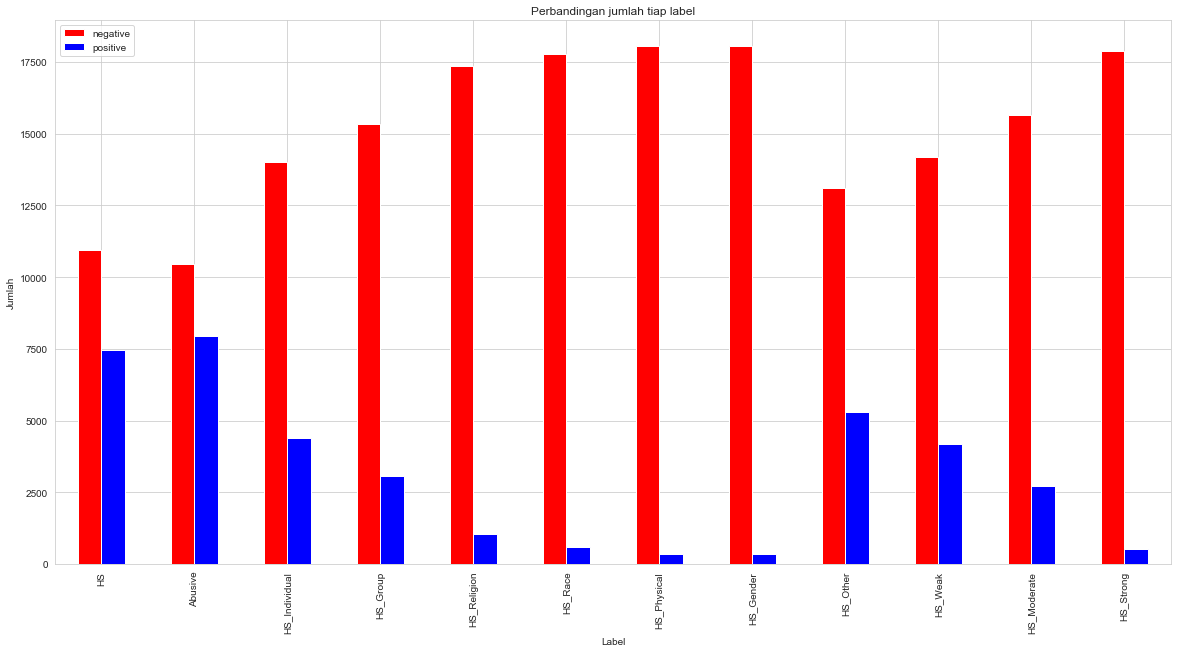

In [6]:
dat_anls.loc[:,['negative','positive']].plot.bar(color=['red','blue'], figsize=(20,10))
plt.title("Perbandingan jumlah tiap label")
plt.xlabel('Label')
plt.ylabel('Jumlah')
plt.show()

In [7]:
dat_anls

,negative,positive
label,,
HS,10947,7449
Abusive,10445,7951
HS_Individual,13999,4397
HS_Group,15344,3052
HS_Religion,17356,1040
HS_Race,17793,603
HS_Physical,18051,345
HS_Gender,18053,343
HS_Other,13101,5295


### Multiple labels per tweet

Text(0.5, 0, '# of labels')

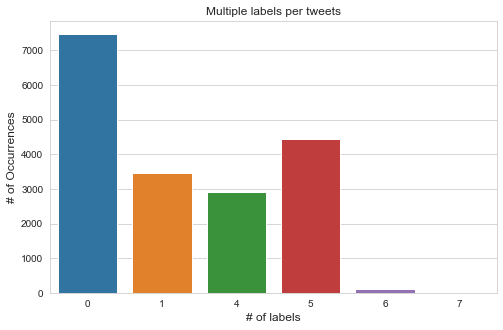

In [8]:
rowsums = data.iloc[:,1:].sum(axis=1)
x=rowsums.value_counts()
#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple labels per tweets")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of labels', fontsize=12)

In [9]:
data.iloc[:,1:].sum(axis=1).value_counts()

0    7475
5    4427
1    3472
4    2911
6     104
7       7
dtype: int64

### Distribusi Panjang Karakter Tweet

In [10]:
data_anl = data[["Tweet"]].copy()

In [11]:
data_anl['Tweet_length'] = data_anl['Tweet'].str.len()

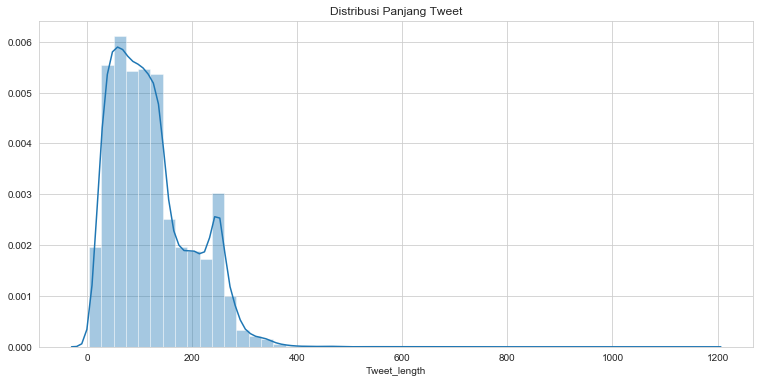

In [12]:
plt.figure(figsize=(12.8,6))
sns.distplot(data_anl['Tweet_length']).set_title('Distribusi Panjang Tweet');

In [13]:
data_anl['Tweet_length'].describe()

count    18396.000000
mean       122.012938
std         74.681796
min          4.000000
25%         63.000000
50%        108.000000
75%        164.000000
max       1173.000000
Name: Tweet_length, dtype: float64

### Distribusi Panjang Kata Tweet

In [14]:
data_anl['word_count'] = data_anl['Tweet'].apply(lambda x: len(str(x).split()))

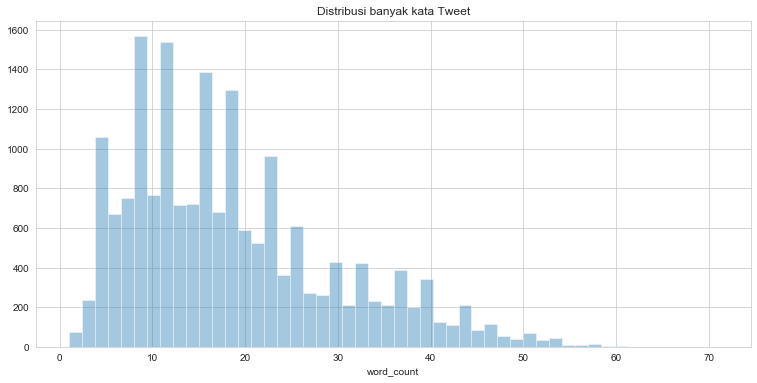

In [15]:
plt.figure(figsize=(12.8,6))
sns.distplot(data_anl['word_count'],kde=False).set_title('Distribusi banyak kata Tweet');

In [16]:
data_anl['word_count'].describe()

count    18396.000000
mean        18.427104
std         11.110092
min          1.000000
25%         10.000000
50%         16.000000
75%         24.000000
max         71.000000
Name: word_count, dtype: float64

### Sampel Tweet

In [17]:
data['Tweet'].iloc[0]

"- disaat semua cowok berusaha melacak perhatian gue. loe lantas remehkan perhatian yg gue kasih khusus ke elo. basic elo cowok bego ! ! !'"

### Top 20 Words

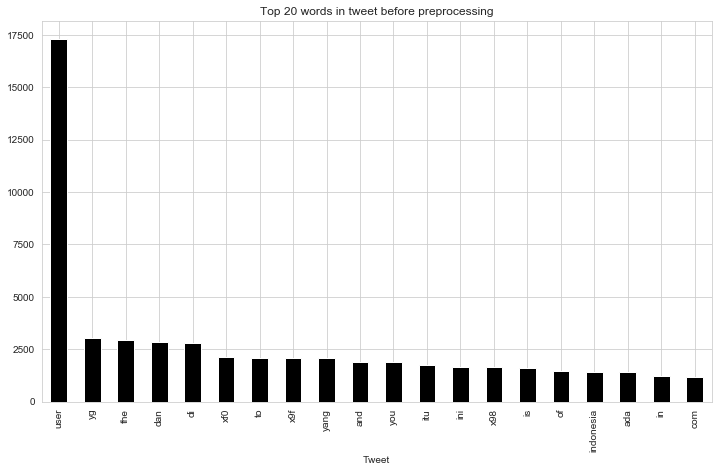

In [18]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(data_anl['Tweet'], 20)
# for word, freq in common_words:
#     print(word, freq)
topWord = pd.DataFrame(common_words, columns = ['Tweet' , 'count'])
topWord.groupby('Tweet').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', y='Count', color='black', title='Top 20 words in tweet before preprocessing', figsize=(12,7))


### Top 20 Bigram

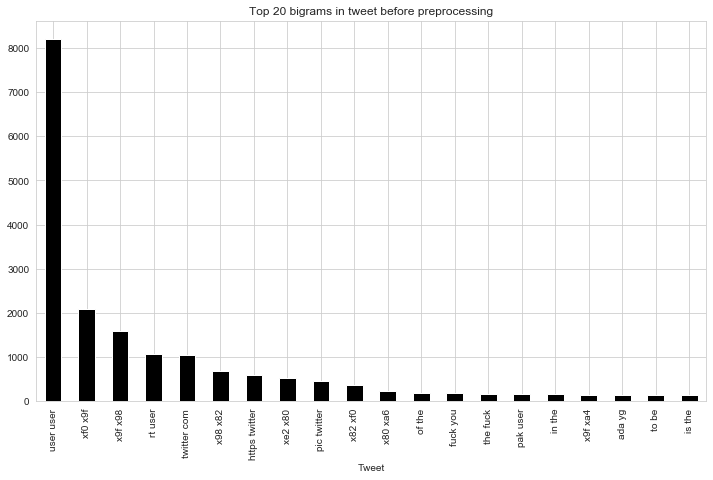

In [19]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(data_anl['Tweet'], 20)
# for word, freq in common_words:
#     print(word, freq)
topbigram = pd.DataFrame(common_words, columns = ['Tweet' , 'count'])
topbigram.groupby('Tweet').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', y='Count', color='black', title='Top 20 bigrams in tweet before preprocessing', figsize=(12,7))


### Language of Words

In [20]:
words = get_top_n_words(data_anl['Tweet'])

In [21]:
lang_count = {}
for i in tqdm(words):
    translator = googletrans.Translator()
    lang = translator.translate(i[0]).src
    lang_amount = i[1]
    if lang not in lang_count.keys():
        lang_count[lang] = lang_amount
    else:
        lang_count[lang] = lang_count[lang]+lang_amount
    time.sleep(2)

  0%|                                                                             | 3/40630 [00:06<25:03:45,  2.22s/it]


KeyboardInterrupt: 

## Store Train and Test Set

In [22]:
X = data[['Tweet']]
y = data.drop(['Tweet'],axis = 1).values

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=8)

In [24]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=8)

In [25]:
data_train = X_train.copy()
data_train = data_train.reset_index(drop=True).join(pd.DataFrame(data=y_train, columns = data.columns[1:]))
data_train.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- kdg will be kind enough to show you how to l...,0,1,0,0,0,0,0,0,0,0,0,0
1,Ternyata komunis juga bisa nangis',0,0,0,0,0,0,0,0,0,0,0,0
2,USER USER Kenapa harus bom ya? Kek yg benar nu...,0,0,0,0,0,0,0,0,0,0,0,0
3,USER Sumpaaah kaya kalo abis IAA dilanjut olim...,0,0,0,0,0,0,0,0,0,0,0,0
4,RT USER USER USER USER USER fungsi media sosia...,1,0,1,0,0,0,0,0,1,1,0,0


In [26]:
data_test = X_test.copy()
data_test = data_test.reset_index(drop=True).join(pd.DataFrame(data=y_test, columns = data.columns[1:]))
data_test.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,GANTENG TAPI BERENGSEK!!! BUAT APA?!!\nWHO DO ...,1,1,1,0,0,0,0,0,1,1,0,0
1,Sakit jiwa kali yah..,0,0,0,0,0,0,0,0,0,0,0,0
2,"Does insulting one for being ""Cina"", ""Kafir"", ...",0,1,0,0,0,0,0,0,0,0,0,0
3,USER USER Karena partaimu pdip itu bajingan',1,1,0,1,0,0,0,0,1,0,1,0
4,USER USER Jgn salah itu janji jokowi yg di tun...,1,1,1,0,0,0,0,0,1,1,0,0


In [27]:
data_val = X_val.copy()
data_val = data_val.reset_index(drop=True).join(pd.DataFrame(data=y_val, columns = data.columns[1:]))
data_val.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,So much berengsek people in the world,1,1,0,1,0,0,0,0,1,0,1,0
1,"So, how can I get my REKBER?? rekening berengsek.",0,1,0,0,0,0,0,0,0,0,0,0
2,RT USER: dasar bajingan!\xf0\x9f\x98\xa0 URL,0,1,0,0,0,0,0,0,0,0,0,0
3,USER Krn cebong tdk akn mengakui pria lajang y...,1,1,0,1,0,0,0,0,1,0,1,0
4,"RT USER: ga ada urusannya, monyet. gua broken ...",1,1,1,0,0,0,0,0,1,1,0,0


In [28]:
data_train.shape

(13244, 13)

In [29]:
data_test.shape

(3680, 13)

In [30]:
data_val.shape

(1472, 13)

In [31]:
data_train.to_csv("../Data/data_train.csv", index=False, sep=";")
data_test.to_csv("../Data/data_test.csv", index=False, sep=";")
data_val.to_csv("../Data/data_val.csv", index=False, sep=";")